# Categorized the Uncategorized

This notebook is all about the categorization of uncategorized data.

It uses **NLP** tools in order to build classifiers. The classifiers can be saved and later re-used.

## Import a few modules

In [1]:
import numpy as np
import pandas as pd
import requests

import time
import random
import glob
import pickle
import scipy
from scipy import misc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)

#import spacy
#from spacy.de import German
#from spacy.en import English
#import memory_profiler
#import nltk.data
#from nltk.tokenize import word_tokenize
#from nltk.tokenize.punkt import PunktSentenceTokenizer
#from nltk.corpus import stopwords

from collections import Counter

import string
import re
import chardet

from pprint import pprint
from time import time

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

import sys, os
if sys.path[-1] == '/Users/jeremie/Documents/random_notebooks/extraModules':
    import nlpTools as nlpt
    import visualisationTools as visut
else:
    sys.path.append('/Users/jeremie/Documents/random_notebooks/extraModules')
    import nlpTools as nlpt
    import visualisationTools as visut

print sys.path[-5:]

['/usr/local/Cellar/numpy/1.11.1/libexec/nose/lib/python2.7/site-packages', '/Library/Python/2.7/site-packages', '/usr/local/lib/python2.7/site-packages/IPython/extensions', '/Users/jeremie/.ipython', '/Users/jeremie/Documents/random_notebooks/extraModules']


## Load the Data

Below we load the data. The data are stored as a big **CSV** file.

In [3]:
# path where to load the data
engage_db_path = "/Users/jeremie/Documents/random_notebooks/data/local_catalogue_items.csv"
df = pd.read_csv(engage_db_path)

# load the data
if df.columns[0] == "Unnamed: 0":
    print "trouble in town, need to reload the bazard."
    del df
    # and reload
    df = pd.read_csv(engage_db_path, index_col=0)
else:
    print "Everything alright, go to work!"
print df.columns


Everything alright, go to work!
Index([u'id', u'environment_agnostic_id', u'category', u'feedCategory',
       u'imageUrls', u'title', u'description', u'brand', u'colour', u'gender',
       u'new_category', u'store_id'],
      dtype='object')


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Look briefly at the data - category names

Here we list all unique category names and do simple visualization.

There are <24> different categories in the column [new_category].
full suit --> 90
scarf --> 65
vest --> 54
tie --> 2
belt --> 29
watches --> 1
glasses --> 42


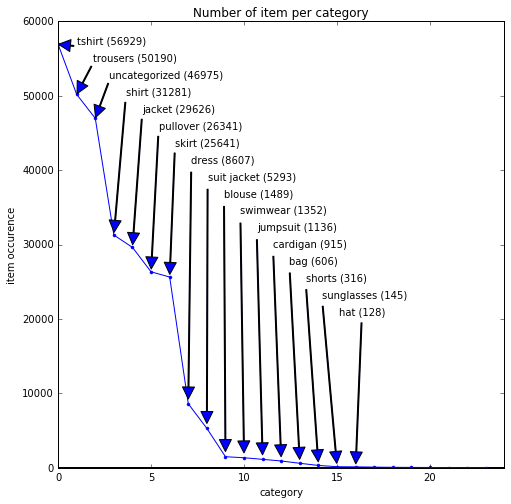

In [4]:
# extract data from the column "new_category" of the dataframe
unique_category_name, unique_category_count = nlpt.fun_get_unique_item_count_and_name(df, "new_category")
for n, c in zip(unique_category_name, unique_category_count):
    if c < 100:
        print "%s --> %1.0f" % (n,c)

# plot colour data
visut.fun_display_category_distribution(unique_category_count, 
                                        unique_category_name, 
                                        limit_size_for_training= 100,
                                        item_name = "category")

### Look briefly at the data - brand names

Here we list all unique brand names.

There are <7365> different categories in the column [brand].


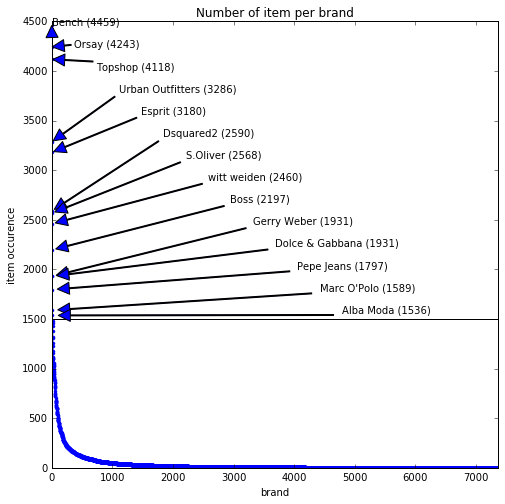

In [5]:
# extract data from the column "new_category" of the dataframe
unique_brand_name, unique_brand_count = nlpt.fun_get_unique_item_count_and_name(df, "brand")

# plot colour data
visut.fun_display_category_distribution(unique_brand_count, 
                                        unique_brand_name, 
                                        limit_size_for_training= 1500,
                                        item_name = "brand")

## Load subset for training and testing

Once loaded, the text data will be **tokenized**, meaning we will work with a numeric representation of the text, to be more specific we will work with a matrice of word occurence from the given training dataset.

The database has text information available for each item: **description**, **title**, **brand**, **colour**. The short study has shown that using only **description** and **title** as text description for a given item is enough. 

In [7]:
# super simple cleaning to remove the \n in the description column
df['description'] = df['description'].str.replace("\n"," ")

# experimental parameters:
column_names = ['title', 'description']

experimentation_name = ''
for nn in np.arange(len(column_names)):
    experimentation_name = experimentation_name + column_names[nn][0]
print experimentation_name

td


## Save all category as text file

The data are saved as txt and pickle file format.

In [8]:
# export each category as text file
unique_category_name, unique_category_count = nlpt.give_info_dataframe_categories(df, column="new_category")
nlpt.save_list_as_text(unique_category_name, 'category_name')
nlpt.save_list_as_text(unique_category_count, 'category_count')

for cat_name in unique_category_name:
    nlpt.save_category_data_as_text(df, cat_name, column_names)

/usr/local/lib/python2.7/site-packages/pandas/indexes/base.py:1275: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  result = getitem(key)


In [10]:
# move the txt/pickle files from ./notebooks to ./tmp folder
!mv *txt ./tmp
!mv *pickle ./tmp
!ls *txt
!ls ./tmp/*_.txt

ls: *txt: No such file or directory
./tmp/bag_td_.txt           ./tmp/scarf_td_.txt
./tmp/belt_td_.txt          ./tmp/shirt_td_.txt
./tmp/blouse_td_.txt        ./tmp/shorts_td_.txt
./tmp/cardigan_td_.txt      ./tmp/skirt_td_.txt
./tmp/category_count_.txt   ./tmp/suit jacket_td_.txt
./tmp/category_name_.txt    ./tmp/sunglasses_td_.txt
./tmp/dress_td_.txt         ./tmp/swimwear_td_.txt
./tmp/full suit_td_.txt     ./tmp/tie_td_.txt
./tmp/glasses_td_.txt       ./tmp/trousers_td_.txt
./tmp/hat_td_.txt           ./tmp/tshirt_td_.txt
./tmp/jacket_td_.txt        ./tmp/uncategorized_td_.txt
./tmp/jumpsuit_td_.txt      ./tmp/vest_td_.txt
./tmp/pullover_td_.txt      ./tmp/watches_td_.txt


In [13]:
# check that the number of line match the number of item for a give category
!wc -l ./tmp/trousers_td_.txt

   50190 ./tmp/trousers_td_.txt


## Load the saved data

The data should now be located in the **../tmp** folder.

There are two options to select train and test data:

+ one will use the number of test and train per category according to some threshold
+ the second takes the same percentage distribution per category.

In [15]:
list_cat_name = pickle.load(open("./tmp/category_name_.pickle","rb"))
list_cat_count = pickle.load(open("./tmp/category_count_.pickle","rb"))

### Fixed number of test and train items

In [17]:
flag_fixed_number_train_test = True
flag_ratio_number_train_test = not flag_fixed_number_train_test

# parameters for the train and test data selection
if flag_fixed_number_train_test:
    print "You did choose the fixed number of test and train data."
    limit_numb_item = 301
    numb_train_data = 100
    numb_test_data  = 100
    flag_index_selection = "fixed_number"
elif flag_ratio_number_train_test:
    print "You did choose the ratio setup."
    limit_numb_item = 10
    val_test_size=0.33
    flag_index_selection = "ratio_number"
else:
    print "Something must be wrong if you end up here."
    
list_cat, tr_, labelsTr_, te_, labelsTe_, te_uncat_ = [],[],[],[],[],[]
list_cat_for_training = []

# select the train and test data
for cat_name, cat_count in zip(list_cat_name, list_cat_count):
    if cat_name == "uncategorized":
        ## LOAD THE DATA
        te_uncat_ = pickle.load(open('./tmp/uncategorized_'+experimentation_name+'_.pickle', 'rb'))

    elif cat_count > limit_numb_item:
        ## LOAD THE data
        list_data = pickle.load(open('./tmp/'+cat_name+'_'+experimentation_name+'_.pickle', 'rb'))
        list_label = list([cat_name] * len(list_data))
        list_cat_for_training.append(cat_name)
        
        ## GENERATE RANDOM index
        if flag_index_selection == "fixed_number":
            ind_ = random.sample(xrange(cat_count), numb_test_data + numb_train_data)
            
            ## SELECT THE SELECTED NUMBER OF items
            for kk in np.arange(0, numb_train_data):
                tr_.append(list_data[ind_[kk]])
                labelsTr_.append(list_label[ind_[kk]])


            for mm in np.arange(numb_train_data, len(ind_)):
                te_.append(list_data[ind_[mm]])
                labelsTe_.append(list_label[ind_[mm]])
        
        elif flag_index_selection == "ratio_number":
            X = np.arange(len(list_data))
            y = np.arange(len(list_data))
            X_train, X_test, y_train, y_test = train_test_split(X,y)        

            ## SELECT THE SELECTED NUMBER OF items
            for kk in np.arange(len(y_train)):
                tr_.append(list_data[y_train[kk]])
                labelsTr_.append(list_label[y_train[kk]])

            for mm in np.arange(len(y_test)):
                te_.append(list_data[y_test[mm]])
                labelsTe_.append(list_label[y_test[mm]])
        
        else:
            print "Houston where are we?"
            break
            
      
        del list_data, list_label
del flag_index_selection

print "We have %1.0f train data and %1.0f test data." % (len(tr_), len(te_))
print "The classifier will take %1.0f categories into account:" % (len(Counter(labelsTe_).keys()))
print sorted(list(Counter(labelsTe_).keys()))

You did choose the fixed number of test and train data.
We have 1400 train data and 1400 test data.
The classifier will take 14 categories into account:
['bag', 'blouse', 'cardigan', 'dress', 'jacket', 'jumpsuit', 'pullover', 'shirt', 'shorts', 'skirt', 'suit jacket', 'swimwear', 'trousers', 'tshirt']


## Training and Evaluating the classifier performances

Below we do:

+ visualise the performances
+ classify the uncategorized

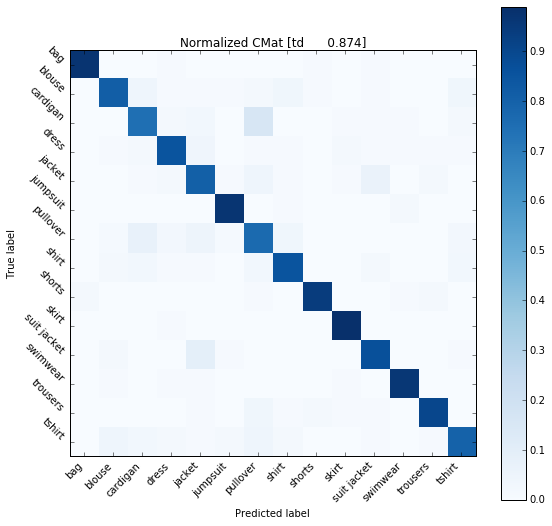

In [18]:
# choose vectorizer
vectorizer = CountVectorizer()
    
# choose classifier
clf  = LinearSVC()

# put everything in a pipe structure, here we use our function
# to clean the text before the vectorization/tokenization
pipe = Pipeline([('cleanText', nlpt.CleanTextTransformer()),
                 ('vectorizer', vectorizer),
                 ('clf', clf)])

# train the system
pipe.fit(tr_, labelsTr_)

# evaluate the model by predicting test data from the same dataset
labelsTe_from_pred = pipe.predict(te_)
global_accuracy_score = accuracy_score(labelsTe_, labelsTe_from_pred)

# compute confusion matrix
conf_matrix = confusion_matrix(labelsTe_from_pred, labelsTe_)
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# visualize the confusion matrix
vec_label = np.unique(labelsTr_)
title_figure = 'Normalized CMat ['+experimentation_name+' '+'{:10.3f}'.format(global_accuracy_score) +']'
plt.figure()
visut.plot_confusion_matrix(cm_normalized, 
                            vec_label, 
                            title= title_figure)
plt.colorbar()
plt.draw()           
plt.show()

### Classify the Uncategorized

Now that we have defined a classifier we can run it and get prediction/classification of random test data.

In [19]:
# classify the uncategorized:
preds_uncat = pipe.predict(te_uncat_)

In [20]:
# show some resuts
index_text_random = np.random.randint(len(te_uncat_))
print "Data index %s." % index_text_random
print "Test data: %s" % te_uncat_[index_text_random]
print "category: <%s>.\n" % preds_uncat[index_text_random]

Data index 44756.
Test data: Emilio Pucci embroidered dislocated fastening coat Blue silk blend and racoon fur embroidered dislocated fastening coat from Emilio Pucci.
category: <swimwear>.



## How to re-use the classifier?

Good news everyone, it is possible to save the classifier for later use!

In [22]:
# below I save the classifier and the vectorizer for later use:
joblib.dump(clf, './tmp/classifier_s.pkl') 
joblib.dump(vectorizer, './tmp/vectorizer_s.pkl') 
!ls *pkl
!ls ./tmp/*pkl

# below I'm reloading the previously save data:
clf2 = joblib.load('./tmp/classifier_s.pkl') 
vectorizer2 = joblib.load('./tmp/vectorizer_s.pkl') 

# and now I'm apply the using the loaded classifier.
pipe2 = Pipeline([('cleanText', nlpt.CleanTextTransformer()),
                  ('vectorizer', vectorizer2),
                  ('clf', clf2)])

# do the prediction again
pred_old = pipe.predict(te_uncat_)
pred_new = pipe2.predict(te_uncat_)

ls: *pkl: No such file or directory
./tmp/classifier_s.pkl ./tmp/vectorizer_s.pkl


In [23]:
# compare the classifiers that should give exactly the same resutl:
index_text_random = np.random.randint(len(te_uncat_))
print "Data index %s." % index_text_random
print "Test data: %s" % te_uncat_[index_text_random]
print "category old: <%s>." % pred_old[index_text_random]
print "category new: <%s>.\n" % pred_new[index_text_random]

Data index 19370.
Test data: Hüftslip „Taylor Dolpin“ Bequemer, lässiger Hüftslip aus superweicher Baumwolle mit farblich abgestimmten Borten. WISSENSWERTES: - Baumwolle und Elastan - Handwäsche
category old: <jacket>.
category new: <jacket>.



# It's a bit experimentat below

So be aware...

## Use Grid Search to get the best parameters

Here we re-do as above but we are looking for the best set of parameters with gridsearch.

This is only possible with the fixed number of train and test data for the experimentation.

I use the approach from here [**http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#example-model-selection-grid-search-text-feature-extraction-py**].

We do

+ define the range of the different parameters
+ run grid search 
+ re-run the experiment with the best parameters

### Define the different parameters

In [24]:
# define the pipeline
pipe_grid_search = Pipeline([
    ('cleanText', nlpt.CleanTextTransformer()),
    ('vectorizer', CountVectorizer()),
    ('clf', LinearSVC()),    
])

#define the range for each parameters
parameters = {'vectorizer__max_df': (0.5, 0.75, 1.0),
             #'vect__max_features': (None, 5000, 10000, 50000),
             'vectorizer__ngram_range': ((1,1), (1, 2), (1,3)),  # unigrams or bigrams
             }

# define the grid_search
grid_search = GridSearchCV(pipe_grid_search, parameters, n_jobs=-1, verbose=1)

# Run the Grid Search
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipe_grid_search.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(tr_, te_)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
('pipeline:', ['cleanText', 'vectorizer', 'clf'])
parameters:
{'vectorizer__max_df': (0.5, 0.75, 1.0),
 'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3))}


/Library/Python/2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.6min finished


done in 249.255s
()
Best score: 0.024
Best parameters set:
	vectorizer__max_df: 0.75
	vectorizer__ngram_range: (1, 3)


### Re-Run with the optimized parameters

In [26]:
pipe_best_parameters = Pipeline([
    ('cleanText', nlpt.CleanTextTransformer()),
    ('vectorizer', CountVectorizer(max_df = best_parameters['vectorizer__max_df'],
                                   ngram_range = best_parameters['vectorizer__ngram_range'])),
    ('clf', LinearSVC()),
])

# train the system
pipe_best_parameters.fit(tr_, labelsTr_)
labelsTe_from_pred = pipe_best_parameters.predict(te_)
global_accuracy_score = accuracy_score(labelsTe_, labelsTe_from_pred)

####################################################################
# below I save the classifier and the vectorizer for later use:
joblib.dump(vectorizer, './tmp/vectorizer_s_opt.pkl') 
joblib.dump(clf, './tmp/classifier_s_opt.pkl')
####################################################################

['./tmp/classifier_s_opt.pkl',
 './tmp/classifier_s_opt.pkl_01.npy',
 './tmp/classifier_s_opt.pkl_02.npy',
 './tmp/classifier_s_opt.pkl_03.npy']

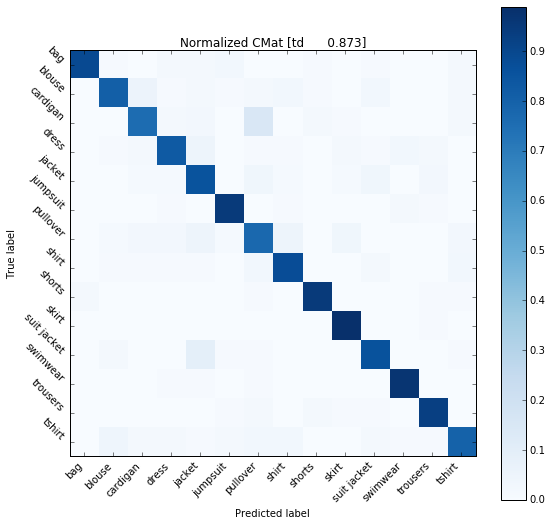

In [27]:
# computer confusion matrix
conf_matrix = confusion_matrix(labelsTe_from_pred, labelsTe_)
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure()
vec_label = np.unique(labelsTr_)
title_figure = 'Normalized CMat ['+experimentation_name+' '+'{:10.3f}'.format(global_accuracy_score) +']'
visut.plot_confusion_matrix(cm_normalized,vec_label, 
                            title= title_figure)
plt.colorbar()
plt.draw()                          
plt.show()

## Define the different parameters

Here we re-run the classification with different parameters and functions.

In [30]:
# define the pipeline
clf = SGDClassifier()
pipe_grid_search2 = Pipeline([
    ('cleanText', nlpt.CleanTextTransformer()),
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', clf),
])

#define the range for each parameters
parameters2 = {
        'vectorizer__max_df': (0.5, 0.75, 1.0),
        #'vectorizer__max_features': (None, 5000, 10000, 50000),
        'vectorizer__ngram_range': ((1,1), (1, 2), (1,3)),  # unigrams or bigrams
        #'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        #'clf__alpha': (0.00001, 0.000001),
        #'clf__penalty': ('l2', 'elasticnet'),
        #'clf__n_iter': (10, 50, 80),
    }

# define the grid_search
grid_search2 = GridSearchCV(pipe_grid_search2, parameters2, n_jobs=-1, verbose=1)

### Run the Grid Search

In [31]:
# start the grid search
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipe_grid_search2.steps])
print("parameters:")
pprint(parameters2)
t0 = time()
grid_search2.fit(tr_, te_)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters2 = grid_search2.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters2[param_name]))

Performing grid search...
('pipeline:', ['cleanText', 'vectorizer', 'tfidf', 'clf'])
parameters:
{'tfidf__norm': ('l1', 'l2'),
 'vectorizer__max_df': (0.5, 0.75, 1.0),
 'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.3min finished


done in 82.059s
()
Best score: 0.024
Best parameters set:
	vectorizer__max_df: 0.5
	vectorizer__ngram_range: (1, 1)


### Re-Run with the optimized parameters

In [32]:
vect = CountVectorizer(max_df = best_parameters2['vectorizer__max_df'],
                       ngram_range = best_parameters2['vectorizer__ngram_range'])
tfidf = TfidfTransformer(#use_idf = best_parameters2['tfidf__use_idf'])#,
                         norm = best_parameters2['tfidf__norm'])
clf = SGDClassifier()#alpha = best_parameters2['clf__alpha'],
                    #penalty = best_parameters2['clf__penalty'],
                   #n_iter = best_parameter2['clf__n_iter'])

pipe_best_parameters2 = Pipeline([
    ('cleanText', nlpt.CleanTextTransformer()),
    ('vectorizer', vect),
    ('tfidf', tfidf),
    ('clf', clf),
])

# train the system
pipe_best_parameters2.fit(tr_, labelsTr_)

labelsTe_from_pred2 = pipe_best_parameters2.predict(te_)
global_accuracy_score = accuracy_score(labelsTe_, labelsTe_from_pred2)

####################################################################
# below I save the classifier and the vectorizer for later use:
joblib.dump(vect, './tmp/vectorizer_s_opt2.pkl') 
joblib.dump(tfidf, './tmp/tfidtransformer_s_opt2.pkl')
joblib.dump(clf, './tmp/classifier_s_opt2.pkl')
####################################################################

['./tmp/classifier_s_opt2.pkl',
 './tmp/classifier_s_opt2.pkl_01.npy',
 './tmp/classifier_s_opt2.pkl_02.npy',
 './tmp/classifier_s_opt2.pkl_03.npy',
 './tmp/classifier_s_opt2.pkl_04.npy']

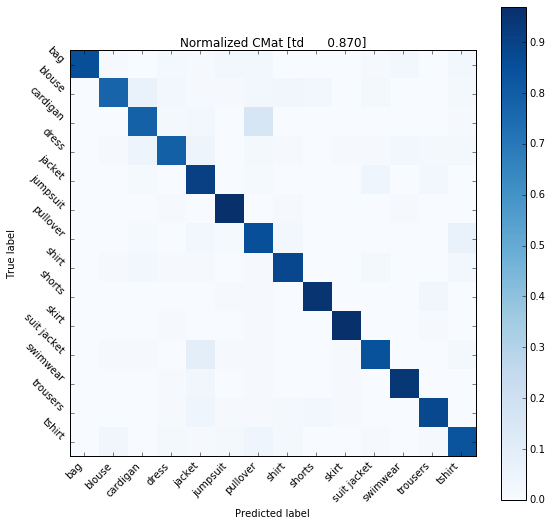

In [33]:
# computer confusion matrix
conf_matrix = confusion_matrix(labelsTe_from_pred2, labelsTe_)
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure()
vec_label = np.unique(labelsTr_)
title_figure = 'Normalized CMat ['+experimentation_name+' '+'{:10.3f}'.format(global_accuracy_score) +']'
visut.plot_confusion_matrix(cm_normalized,vec_label, 
                            title= title_figure)
plt.colorbar()
plt.draw()                          
plt.show()

## Use the best classifier to categorized all the uncategorized

Below we apply the classifiers with the best parameters.

We should also save the dataFrame for later usages with the updated information.

In [34]:
# load the save best classifier
vectorizer_opt = joblib.load('./tmp/vectorizer_s_opt2.pkl') 
tfidf_opt = joblib.load('./tmp/tfidtransformer_s_opt2.pkl')
clf_opt = joblib.load('./tmp/classifier_s_opt2.pkl') 

# and now I'm apply the using the loaded classifier.
pipe3 = Pipeline([('cleanText', nlpt.CleanTextTransformer()),
                  ('vectorizer', vectorizer_opt),
                  ('tfidf', tfidf_opt),
                  ('clf', clf_opt)])

In [35]:
# do all prediction
pred_old_opt = pipe_best_parameters2.predict(te_uncat_)
pred_new_opt = pipe3.predict(te_uncat_)

In [36]:
# compare the classifiers that should give exactly the same resutl:
index_text_random = np.random.randint(len(te_uncat_))
print "Data index %s." % index_text_random
print "Test data: %s" % te_uncat_[index_text_random]
print "category old: <%s>." % pred_old_opt[index_text_random]
print "category new: <%s>.\n" % pred_new_opt[index_text_random]

Data index 28965.
Test data: Bluse aus Spitze mit Biesen Die Pre-Fall-Kollektion 2016 von Philosophy di Lorenzo Serafini präsentiert sich mit einer femininen Ästhetik, die mit Elementen, die an die Edwardische Epoche erinnern, aufgeladen wurde. Diese schwarze Bluse zeichnet sich durch Details im Vintage-Stil aus, wie etwa elegante Biesen an der Passe, Kunstperlenknöpfe und Samtbänder am Kragen. Ein besonderes Highlight bildet dabei der hübsche filigrane Fransenbesatz am Saum und den Bündchen. Mit einem gleichfarbigen BH oder Top schaffen Sie einen harmonischen Ausgleich zum durchscheinenden Finish.
category old: <blouse>.
category new: <blouse>.



## Dow the Categorization on the missing data

Actually this was already done above, now we save it to the dataFrame.

In [39]:
#save the index of the uncategorized data
aa = df[df['new_category'] == "uncategorized"]
index_uncategorized = np.asarray(aa.index)

print len(preds_uncat), len(index_uncategorized)
print preds_uncat[0:10]

46975 46975
['jacket' 'suit jacket' 'cardigan' 'pullover' 'blouse' 'blouse' 'jacket'
 'dress' 'dress' 'suit jacket']


In [40]:
# replace missing categories in the dataframe
# this seems to corrupts the file when I save is as a csv file.
#df.loc[index_uncategorized,"new_category"] = list(preds_uncat)
for ii in np.arange(len(index_uncategorized)):
    df.loc[index_uncategorized[ii],"new_category"] = preds_uncat[ii]

There are <23> different categories in the column [new_category].


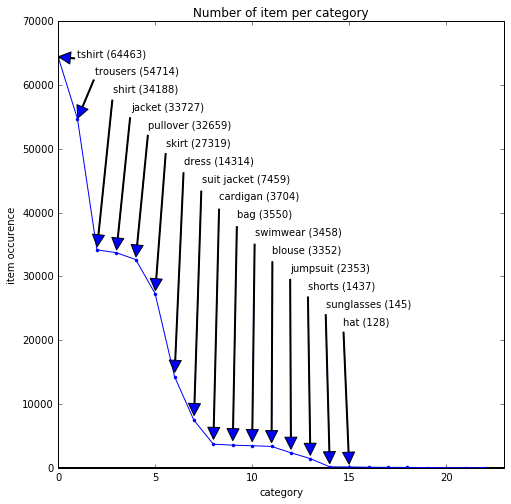

In [41]:
# extract data from the column "new_category" of the dataframe
unique_category_name, unique_category_count = nlpt.fun_get_unique_item_count_and_name(df, "new_category")

# plot colour data
visut.fun_display_category_distribution(unique_category_count, 
                                        unique_category_name, 
                                        limit_size_for_training= 100,#np.ma.median(unique_category_count),
                                        item_name = "category")

## Save the Dataframe to CSV

From now the data **uncategorized** have been **categorized**.

Below we save the column **new_category** as a single

In [43]:
# to save a dataframe to csv:
df['new_category'].to_csv("/Users/jeremie/Documents/random_notebooks/tmp/categories_categorized.csv")
